Going to look at each of these and rank them into 3 groups - 1 being the most able to reconstruct and 3 being low S2N or lacking sufficient coverage.

In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
from astropy.io import fits
import pandas as pd
import sys
#sys.path.append("/Volumes/Macintosh HD 1/Users/trevormccaffrey/Desktop/HST/AllHSTCode/")
#sys.path.append("/Users/Trevor1/Dropbox/HST/HSTCode/")
sys.path.append("/Users/trevormccaffrey/Dropbox/HST/HSTCode/")
from Small_Pix_Filter_TVM import SDSS_pixel_filter
#Use the package that Amy used for determining weights
from lmfit import minimize, Parameters

In [2]:
mpl_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
len(mpl_colors)

10

---

In [3]:
#ica_path = "/Users/trevormccaffrey/Desktop/Research/GTR/Cosmo/ML/ICAcomponents_amy/"
#ica_path = "/Volumes/Macintosh HD 1/Users/trevormccaffrey/Desktop/Research/GTR/Cosmo/ML/ICAcomponents_amy/"
#ica_path = "/Users/Trevor1/Dropbox/HST/ICA/"
ica_path = "/Users/trevormccaffrey/Dropbox/HST/ICA/"

#Load in ICA components and save in Dataframe
cmod = pd.read_csv(ica_path+"amy_12603000_10c_180421.comp", sep="\s+", 
                    names=["c1","c2","c3","c4","c5","c6","c7","c8","c9","c10"])
clow = pd.read_csv(ica_path+"amy_12753000_lowew_10c_181101_v1.comp", sep="\s+", 
                    names=["c1","c2","c3","c4","c5","c6","c7","c8","c9","c10"])
chigh = pd.read_csv(ica_path+"amy_12653000_hew_hsn_7c_190302.comp", sep="\s+", 
                    names=["c1","c2","c3","c4","c5","c6","c7"])
#Load in wave arrays for each set of components
wave_mod = pd.read_csv(ica_path+"wav_12603000.dat", names=["wave"]).values.flatten()
wave_low = pd.read_csv(ica_path+"wav_12753000.dat", names=["wave"]).values.flatten()
wave_high= pd.read_csv(ica_path+"wav_12653000.dat", names=["wave"]).values.flatten()

In [4]:
components_mod  = np.array([cmod.iloc[:,i].values for i in range(cmod.shape[1])])
components_low  = np.array([clow.iloc[:,i].values for i in range(clow.shape[1])])
components_high = np.array([chigh.iloc[:,i].values for i in range(chigh.shape[1])])

In [5]:
def emission_lines(wavelength):
    LyA     = ( (wavelength>1180) & (wavelength<1270) )
    SiIV    = ( (wavelength>1370) & (wavelength<1430) )
    CIV     = ( (wavelength>1510) & (wavelength<1580) )
    CIII    = ( (wavelength>1870) & (wavelength<1935) )
    MgII    = ( (wavelength>2770) & (wavelength<2835) )
    HG      = ( (wavelength>4320) & (wavelength<4370) )
    HB_OIII = ( (wavelength>4835) & (wavelength<5030) )
    HA      = ( (wavelength>6530) & (wavelength<6600) )
    return ( LyA | CIV | CIII | MgII | HB_OIII | HA )

def residual(params, comps, data, eps_data):
    model = sum(params[w].value*comps[n] for (n, w) in enumerate(params))
    return (data-model)**2 * eps_data

def ICA_fit(components, wave, spectrum, ivar, flags):
    params = Parameters()
    for i in range(len(components)):
        params.add('W%d' % (i+1), value=0)
    #MASK = mask(components, wave, spectrum, ivar, flags)
    #print(components.shape, spectrum.shape)
    
    badpix = masking(wave, spectrum, 1/np.sqrt(ivar))
    ivar[badpix|(flags!=0)] = 0
    
    return minimize(residual, params, args=(components, spectrum, ivar), method="lbfgsb", nan_policy='omit')

In [6]:
def do_ICA(wave, flux, errs, mask, name, plot_spectrum=True):
    
    #Apply mask and get fits
    mod_mask  = (wave>1260)&(wave<3000)
    low_mask  = (wave>1275)&(wave<3000)
    high_mask = (wave>1265)&(wave<3000)
    
    mod_comp_mask = (wave_mod>min(wave[mod_mask]))&(wave_mod<max(wave[mod_mask]))
    low_comp_mask = (wave_low>min(wave[low_mask]))&(wave_low<max(wave[low_mask]))
    high_comp_mask = (wave_high>min(wave[high_mask]))&(wave_high<max(wave[high_mask]))
    
    #print(mod_comp_mask.shape)
    ###########
    #Adjust array sizes
    wave_mod_fit = wave_mod[mod_comp_mask]
    components_mod_fit = components_mod[:,mod_comp_mask] 
    wave_low_fit = wave_low[low_comp_mask]
    components_low_fit = components_low[:,low_comp_mask] 
    wave_high_fit = wave_high[high_comp_mask]
    components_high_fit = components_high[:,high_comp_mask]
    
    ###############
    #Now do fitting
        
    # mod EW
    #print(len(wave[mod_mask]), len(wave_mod_fit))
    if len(wave[mod_mask])==len(wave_mod_fit):
        fit_mod  = ICA_fit(components_mod_fit, wave[mod_mask], flux[mod_mask], 1/(errs[mod_mask]**2), mask[mod_mask])
    else:
        #input wave is greater by one pixel, cut components byb one
        if len(wave[mod_mask])-len(wave_mod_fit) == -1:
            fit_mod  = ICA_fit(components_mod_fit[:,:-1], wave[mod_mask], flux[mod_mask], 1/(errs[mod_mask]**2), mask[mod_mask])
        elif len(wave[mod_mask])-len(wave_mod_fit) == 1:
            fit_mod  = ICA_fit(components_mod_fit, wave[mod_mask][:-1], flux[mod_mask][:-1], 1/(errs[mod_mask][:-1]**2), mask[mod_mask][:-1])
    #low EW
    if len(wave[low_mask])==len(wave_low_fit):
        fit_low  = ICA_fit(components_low_fit, wave[low_mask], flux[low_mask], 1/(errs[low_mask]**2), mask[low_mask])
    else:
        #input wave is greater by one pixel, cut components byb one
        if len(wave[low_mask])-len(wave_low_fit) == -1:
            fit_low  = ICA_fit(components_low_fit[:,:-1], wave[low_mask], flux[low_mask], 1/(errs[low_mask]**2), mask[low_mask])
        elif len(wave[low_mask])-len(wave_low_fit) == 1:
            fit_low  = ICA_fit(components_low_fit, wave[low_mask][:-1], flux[low_mask][:-1], 1/(errs[low_mask][:-1]**2), mask[low_mask][:-1])

    #high EW
    if len(wave[high_mask])==len(wave_high_fit):
        fit_high  = ICA_fit(components_high_fit, wave[high_mask], flux[high_mask], 1/(errs[high_mask]**2), mask[high_mask])
    else:
        #input wave is greater by one pixel, cut components byb one
        if len(wave[high_mask])-len(wave_high_fit) == -1:
            fit_high  = ICA_fit(components_high_fit[:,:-1], wave[high_mask], flux[high_mask], 1/(errs[high_mask]**2), mask[high_mask])
        elif len(wave[high_mask])-len(wave_high_fit) == 1:
            #print(wave_high_fit.shape, wave[high_mask].shape)
            fit_high  = ICA_fit(components_high_fit, wave[high_mask][:-1], flux[high_mask][:-1], 1/(errs[high_mask][:-1]**2), mask[high_mask][:-1])
        
    #fit_mod   = ICA_fit(components_mod[:,mod_comp_mask], wave[mod_mask], flux[mod_mask], 1/(errs[mod_mask]**2), mask[mod_mask]) if len(wave[mod_mask])==len(wave_mod) else ICA_fit(components_mod[:,:-1], wave[mod_mask], flux[mod_mask], 1/(errs[mod_mask]**2), mask[mod_mask])
    #fit_low   = ICA_fit(components_low[:,mod_comp_mask], wave[low_mask], flux[low_mask], 1/(errs[low_mask]**2), mask[low_mask]) if len(wave[low_mask])==len(wave_low) else ICA_fit(components_low[:,:-1], wave[low_mask], flux[low_mask], 1/(errs[low_mask]**2), mask[low_mask])
    #fit_high  = ICA_fit(components_high[:,mod_comp_mask], wave[high_mask], flux[high_mask], 1/(errs[high_mask]**2), mask[high_mask]) if len(wave[high_mask])==len(wave_high) else ICA_fit(components_high[:,:-1], wave[high_mask], flux[high_mask], 1/(errs[high_mask]**2), mask[high_mask])
    
    #compute weights
    weights_mod  = [fit_mod.params[i].value for i in fit_mod.params]
    weights_low  = [fit_low.params[i].value for i in fit_low.params]
    weights_high = [fit_high.params[i].value for i in fit_high.params]
    
    if plot_spectrum:
        
        if fit_mod.redchi < fit_high.redchi and fit_mod.redchi < fit_low.redchi:
            #And plot
            #fig, [ax1,ax2,ax3] = plt.subplots(3, 1, figsize=(17,20))
            fig = plt.figure(figsize=(17,6))
            plt.plot(wave, flux)
            plt.plot(wave_mod, np.dot(weights_mod, components_mod), lw=3.5)
            plt.ylim(np.nanpercentile(flux, 1), np.nanpercentile(flux, 99))#max(np.dot(weights_low, components_low)))
            plt.xscale("log")
            plt.title("Moderate EW - %s"%(name))
            plt.show()
            return wave_mod, np.dot(weights_mod, components_mod)
        
        elif fit_low.redchi < fit_high.redchi and fit_low.redchi < fit_mod.redchi:
            #And plot
            fig = plt.figure(figsize=(17,6))
            plt.plot(wave, flux)
            plt.plot(wave_low, np.dot(weights_low, components_low), lw=3.5)
            plt.ylim(np.nanpercentile(flux, 1), np.nanpercentile(flux, 99))#max(np.dot(weights_low, components_low)))
            plt.xscale("log")
            plt.title("Low EW - %s"%(name))
            plt.show()
            return wave_low, np.dot(weights_low, components_low)
        
        else:
            #And plot
            fig = plt.figure(figsize=(17,6))
            plt.plot(wave, flux)
            plt.plot(wave_high, np.dot(weights_high, components_high), lw=3.5)
            plt.ylim(np.nanpercentile(flux, 1), np.nanpercentile(flux, 99))#max(np.dot(weights_high, components_high)))
            plt.xscale("log")
            plt.title("High EW - %s"%(name))
            plt.show()
            return wave_high, np.dot(weights_high, components_high)
        """
        ax1.plot(wave, flux)
        ax1.plot(wave_low, np.dot(weights_low, components_low), lw=3.5)
        ax1.set_ylim(np.nanpercentile(flux, 1), max(np.dot(weights_low, components_low)))
        ax1.set_xscale("log")
        ax1.set_title("Moderate EW")

        ax2.plot(wave, flux)
        ax2.plot(wave_mod, np.dot(weights_mod, components_mod), lw=3.5)
        ax2.set_ylim(np.nanpercentile(flux, 1), max(np.dot(weights_mod, components_mod)))
        ax2.set_xscale("log")
        ax2.set_title("Low EW")

        ax3.plot(wave, flux)
        ax3.plot(wave_high, np.dot(weights_high, components_high), lw=3.5)
        ax3.set_ylim(np.nanpercentile(flux, 1), max(np.dot(weights_high, components_high)))
        ax3.set_xscale("log")
        ax3.set_title("High EW")

        plt.suptitle(name)
        """

        #plt.show()
    
    if fit_mod.redchi < fit_high.redchi and fit_mod.redchi < fit_low.redchi:
        return wave_mod, np.dot(weights_mod, components_mod)
    elif fit_low.redchi < fit_high.redchi and fit_low.redchi < fit_mod.redchi:
        return wave_low, np.dot(weights_low, components_low)
    else:
        return wave_high, np.dot(weights_high, components_high)

In [7]:
N = 0
#path = "/Users/Trevor1/Dropbox/HST/Sulentic_spectra/Sulentic_rebinned/"
path = "/Users/trevormccaffrey/Dropbox/HST/Sulentic_spectra/Sulentic_rebinned/"
for spec in [x for x in os.listdir(path) if not x.startswith(".")]:
    strlist = spec.split("_")
    if "FOS" in strlist:
        #print("%s%s"%(path,spec))
        #print(strlist[0])
        N+=1
print(N)

117


In [8]:
#sul_dat = pd.read_csv("/Users/Trevor1/Dropbox/HST/Sulentic_spectra/Sulentic2007Info_wpaths.csv")
sul_dat = pd.read_csv("/Users/trevormccaffrey/Dropbox/HST/Sulentic_spectra/Sulentic2007Info_wpaths.csv")
sul_dat.head()

,IAU,Instrument,FOS_Name,S2N_group,STIS_Name,COS_Name,HST_Opt,Inst_final,S2N_coadd,z,...,_RA,_DE,SDSS Spectra,SDSS_NAME,RA,DEC,PLATE,MJD,FIBERID,Separation
0,J02019-1132,FOS,3C057,1.0,None,None,NaN,FOS,99,0.6713,...,30.488250,-11.542639,yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,J03514-1429,FOS,3C095,1.0,None,None,NaN,FOS,18,0.6160,...,57.869083,-14.485611,yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,J04172-0553,FOS,3C110,2.0,None,None,NaN,FOS,65,0.7744,...,64.319917,-5.896000,yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,J08407+1312,FOS,3C207,1.0,None,None,NaN,FOS,24,0.6804,...,130.198285,13.206546,yes,084047.58+131223.5,130.198288,13.206544,2426.0,53795.0,625.0,0.011913
4,J09065+1646,FOS,3C215,1.0,None,None,NaN,FOS,21,0.4113,...,136.632750,16.769972,yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
sul_name = sul_dat["FOS_Name"].values
col_num  = np.where(sul_dat.columns=="S2N_group")[0][0]
S2N_groupnum = [3]

In [10]:
def plot_spec(wave, flux, fluxerr, mask_orig, Name):
    
    fig = plt.figure(figsize=(17,6))
    
    morphed_flux, morph_coeff = morph(wave, flux)
    flux *= np.nanmedian(morph_coeff)
    
    plt.plot(wave, flux, alpha=0.3)
    plt.plot(wave, morphed_flux)
    plt.ylim(np.nanpercentile(flux, 1), np.nanpercentile(flux, 99))
    plt.xlim(min(wave),max(wave))
    plt.xscale("log")
    plt.title(Name, fontsize=25)
    
    
    #badpix = masking(wave, flux, fluxerr)
    
    ticks = np.array([1200,1500,1750,2000,2200,2500,3000,3500,4000,4500,5000,6000,7000,8000])
    ticks_use = ticks[(ticks>min(wave))&(ticks<max(wave))]
    plt.xticks(ticks_use)
    plt.gca().get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    plt.gca().get_xaxis().set_tick_params(which='minor', size=0)
    plt.gca().get_xaxis().set_tick_params(which='minor', width=0)
    plt.minorticks_off()
    
    plt.show()
    
def morph(wave, flux):
        #vb01 = np.load("/Volumes/MyPassportforMac/HST/AllData/vandenberk01_continuum.npy")
        #vb01 = np.load("/Users/Trevor1/Dropbox/HST/ICA/vandenberk01_continuum.npy")
        vb01 = np.load("/Users/trevormccaffrey/Dropbox/HST/ICA/vandenberk01_continuum.npy")
        vb01_wave = vb01[:,0]
        vb01_flux = vb01[:,1]

        mask_exp = (vb01_wave>=wave[0])&(vb01_wave<=wave[-1])
        wave_morph = vb01_wave[mask_exp]
        cont_morph = vb01_flux[mask_exp]

        #Now fit continuum of this spectrum
        markers = np.array([1145,1290,1450,1690,1810,1985,2200,2660,2915,3550,4200,4720,5150,6470,6650,7000])
        good_mask = ( (~np.isnan(flux)) & (flux!=0) )
        argstart = max(5, np.abs(wave-wave[good_mask][0]).argmin())
        argfin   = min(len(wave)-5, np.abs(wave-wave[good_mask][-1]).argmin())
        use_markers = markers[(markers>=wave[argstart])&(markers<=wave[argfin])]

        
        #use_markers = np.append(use_markers, wave[-5])
        cont_region = {}

        for i in range(len(use_markers)-1):
            ind1 = abs(wave-use_markers[i]).argmin()
            ind2 = abs(wave-use_markers[i+1]).argmin()
            #print([wave[(ind1-5):(ind1+5)], wave[(ind2-5):(ind2+5)]],
            #                        [flux[(ind1-5):(ind1+5)], flux[(ind2-5):(ind2+5)]])
            fit_region = np.polyfit([np.nanmedian(wave[(ind1-5):(ind1+5)]), np.nanmedian(wave[(ind2-5):(ind2+5)])],
                                    [np.nanmedian(flux[(ind1-5):(ind1+5)]), np.nanmedian(flux[(ind2-5):(ind2+5)])],
                                     1) #do a linear fit on this section

            if len(use_markers)-2==0:
                x = wave
            elif i==0:
                x = wave[:ind2]
            elif i==(len(use_markers)-2):
                x = wave[ind1:]
            else:
                x = wave[ind1:ind2]
            y = fit_region[0]*x + fit_region[1]
            cont_region[i] = [x, y]

        cont_spec = cont_region[0][1]
        for i in range(1, len(use_markers)-1):
            cont_spec = np.append(cont_spec, cont_region[i][1])
            
        if len(cont_spec)-len(cont_morph)==1:
            cont_morph = np.append(cont_morph, cont_morph[-1]) #fix an annoying index error below, coming from definition of mask_exp

        #morph_coeff = (cont_morph/np.nanmedian(vb01_flux)) / (cont_spec/median) #/median attempts to preserve units
        cont_morph = SDSS_pixel_filter(wave, cont_morph, 300)
        cont_spec = SDSS_pixel_filter(wave, cont_spec, 300)
        morph_coeff = cont_morph / cont_spec
        
        #for marker in use_markers:
        #    marker_ind = np.argmin(abs(wave-marker))
        #    plt.scatter(marker, flux[marker_ind]*np.nanmedian(morph_coeff), color="r", s=100, zorder=3)
        #plt.plot(wave,cont_spec*np.nanmedian(cont_morph),alpha=0.3)
        #plt.plot(wave,cont_morph)
        return flux * morph_coeff, morph_coeff #np.nanmedian(morph_coeff)
    
def masking(wave, flux, fluxerr):
    mask_fit = np.zeros(len(flux))
    median_flux = SDSS_pixel_filter(wave, flux)
    median_err  = SDSS_pixel_filter(wave, fluxerr)
    em = emission_lines(wave)
    for j in range(len(median_flux)):
        if ( (abs(flux[j]-median_flux[j]) > 4*abs(median_err[j])) ):#  and ~em[j] ): #change condition as needed
            mask_fit[j] = 1
    return (mask_fit==1)

N = 2.00, Try Number 0


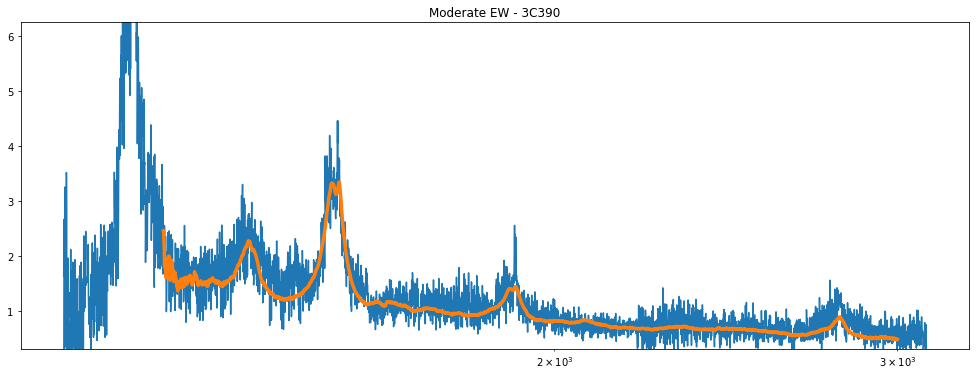

N = 3.75, Try Number 1


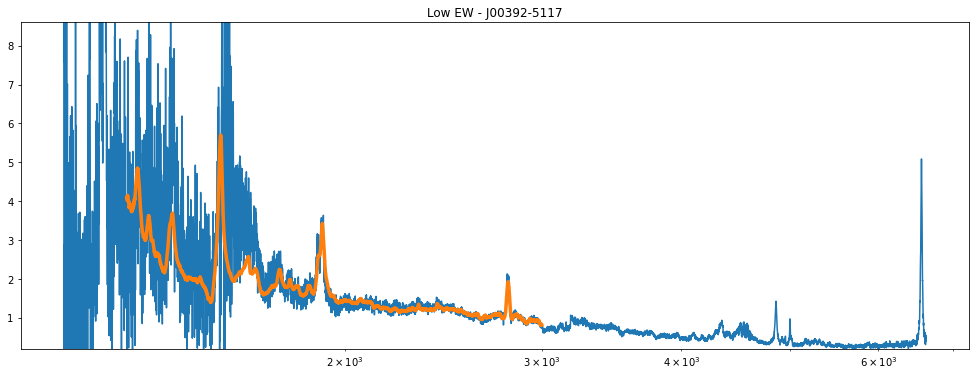

N = 4.00, Try Number 0


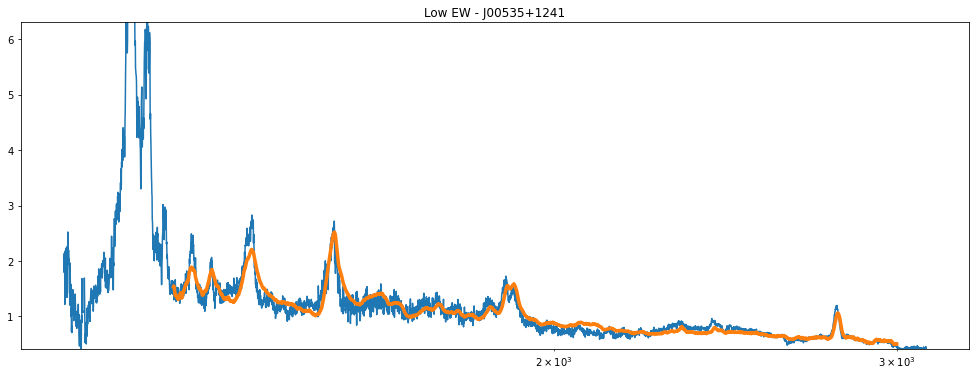

/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in true_divide
/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in true_divide
/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in true_divide


N = 2.00, Try Number 0


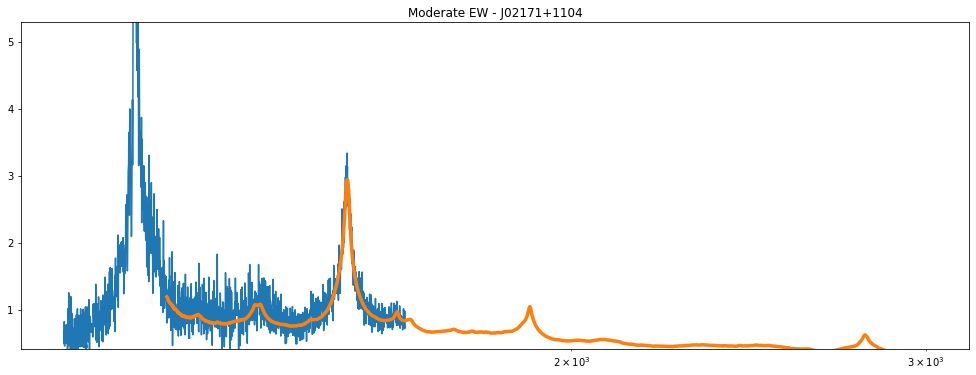

N = 3.00, Try Number 1


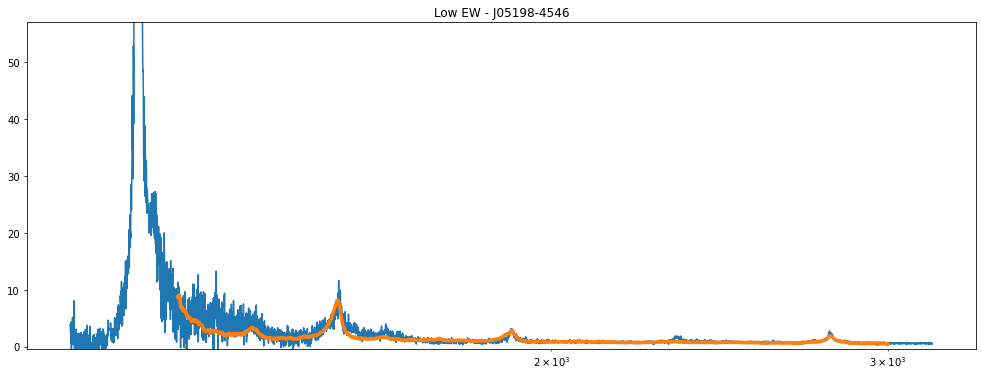

/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in true_divide
/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in true_divide
/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in true_divide


N = 2.00, Try Number 0


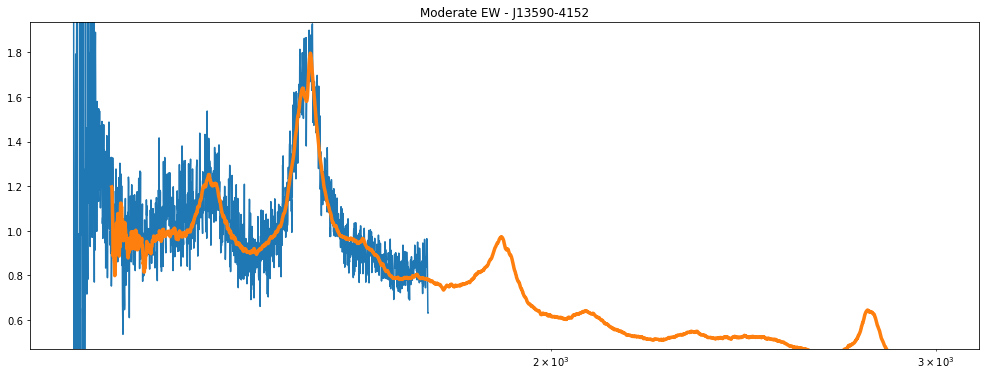

/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in true_divide
/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in true_divide
/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in true_divide


N = 2.00, Try Number 0


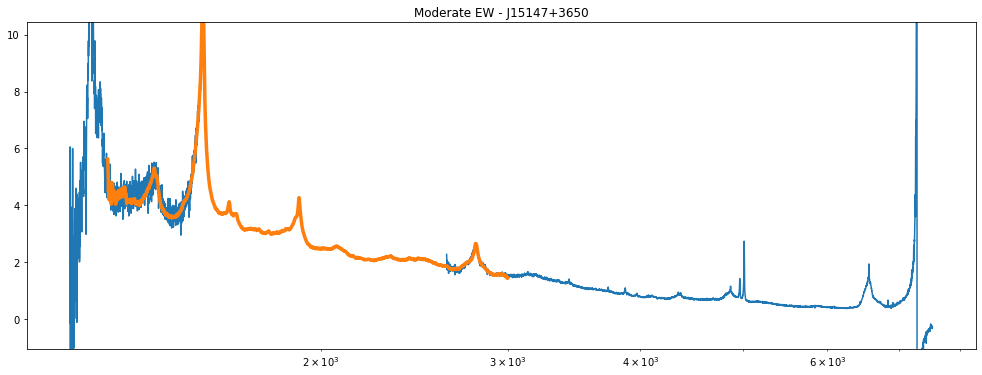

/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in true_divide
/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in true_divide
/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in true_divide


N = 2.00, Try Number 0


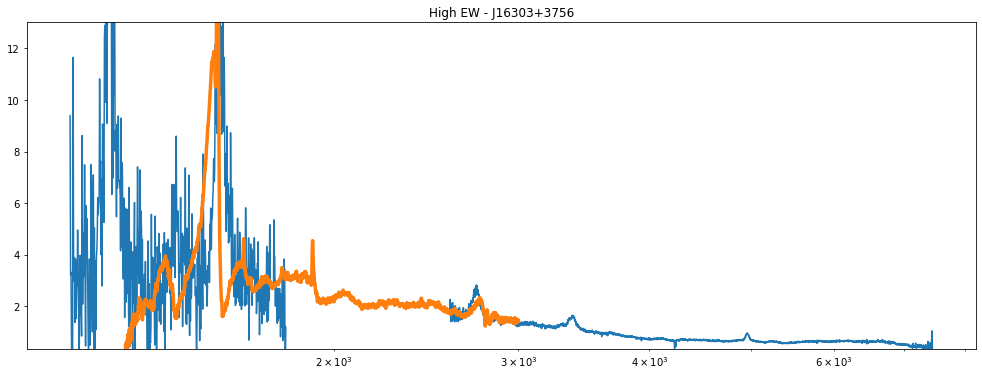

/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in true_divide
/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in true_divide
/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in true_divide


N = 2.00, Try Number 0


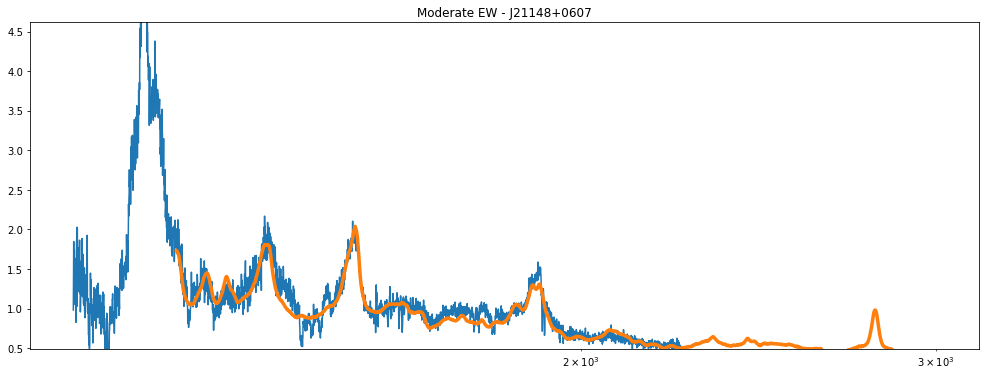

/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in true_divide
/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in true_divide
/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in true_divide


N = 2.00, Try Number 0


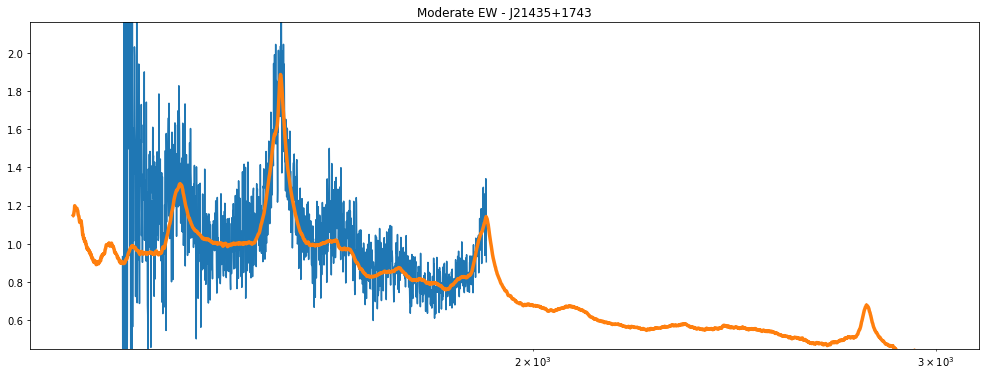

/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in true_divide
/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in true_divide
/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in true_divide


N = 2.00, Try Number 0


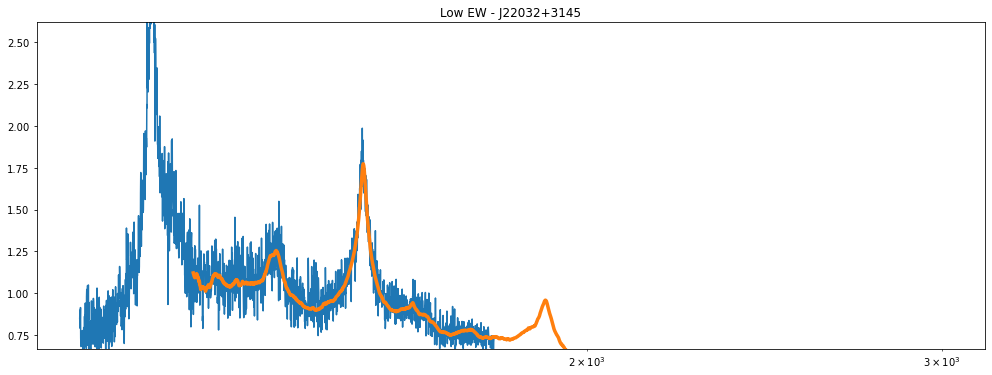

/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in true_divide
/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in true_divide
/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in true_divide


N = 2.00, Try Number 0


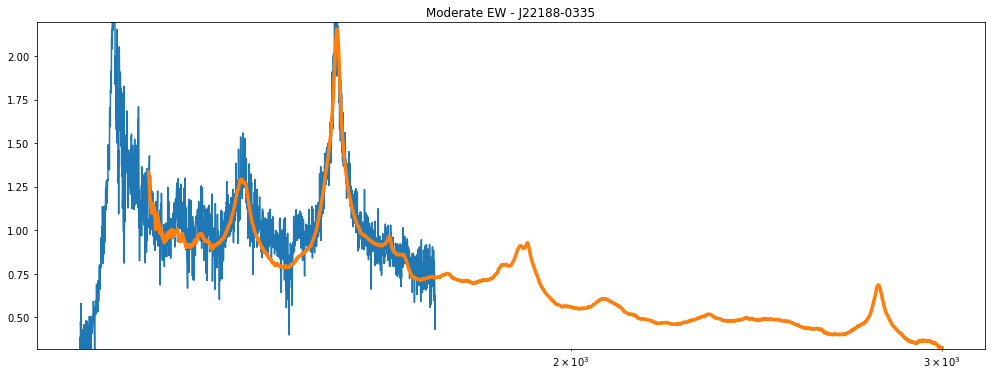

/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in true_divide
/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in true_divide
/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in true_divide


N = 2.00, Try Number 0


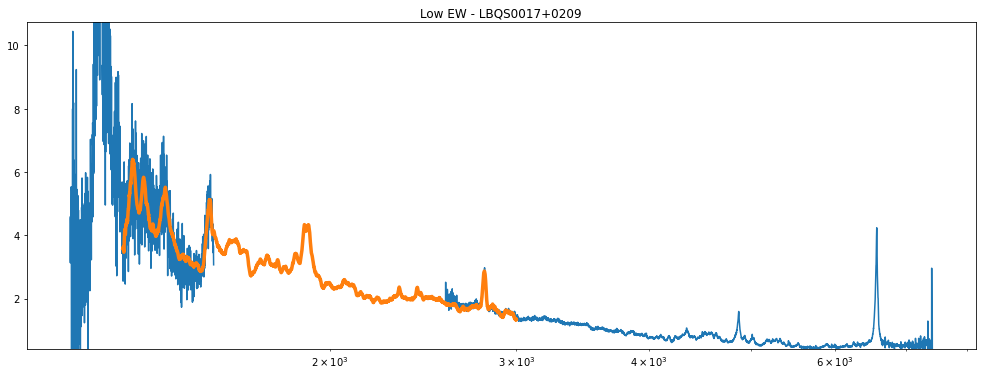

/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in true_divide
/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in true_divide
/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in true_divide


N = 2.00, Try Number 0


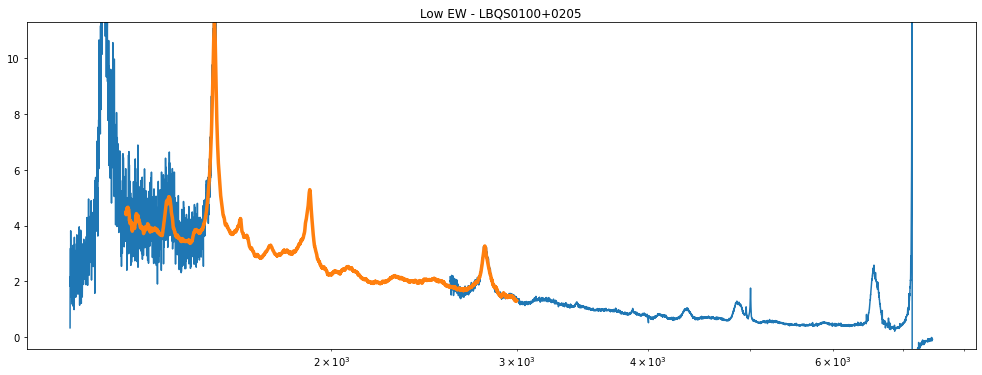

/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in true_divide
/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in true_divide
/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in true_divide


N = 2.00, Try Number 0


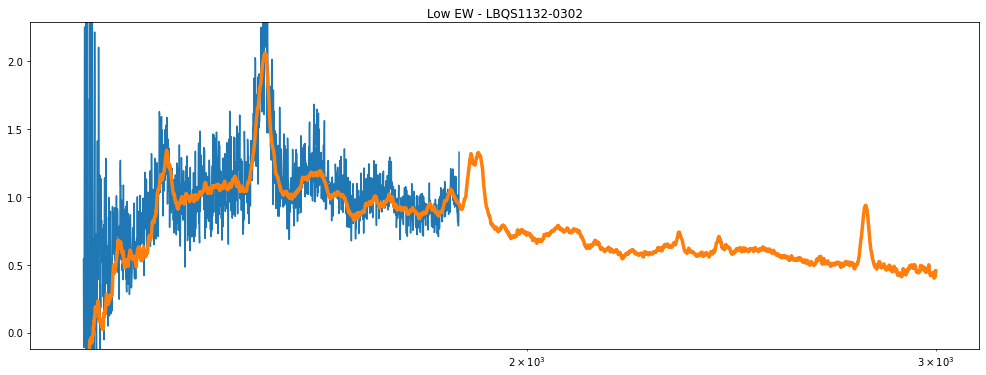

/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in true_divide
/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in true_divide
/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in true_divide


N = 2.00, Try Number 0


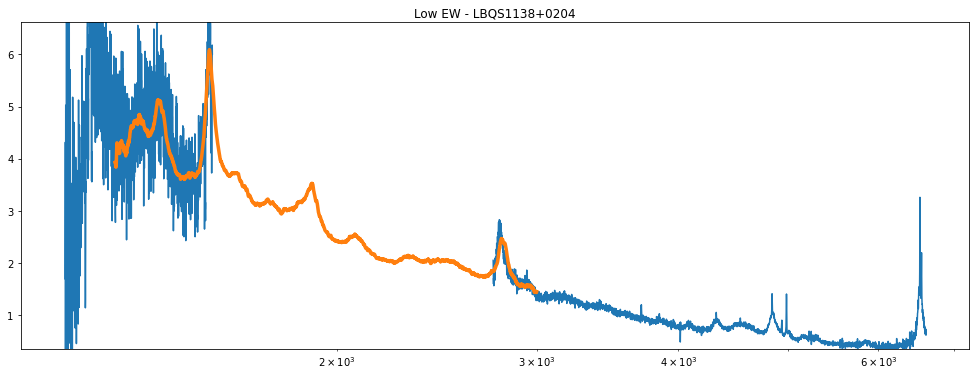

/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in true_divide
/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in true_divide
/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in true_divide


N = 2.00, Try Number 0


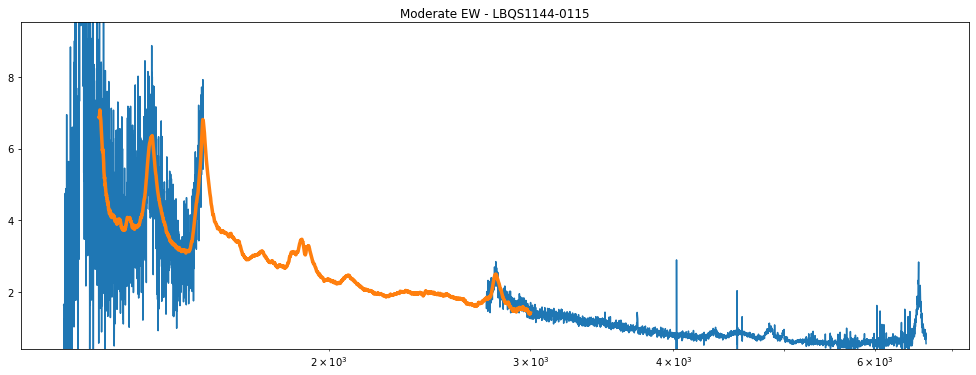

/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in true_divide
/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in true_divide
/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in true_divide


N = 2.00, Try Number 0


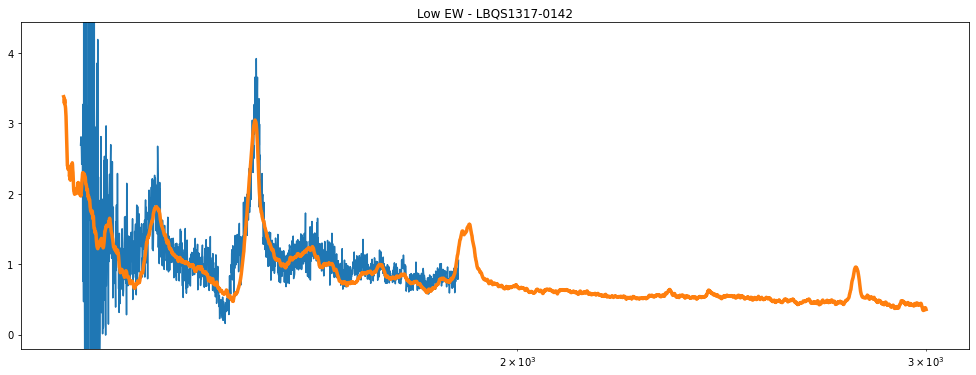

/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


N = 3.00, Try Number 1


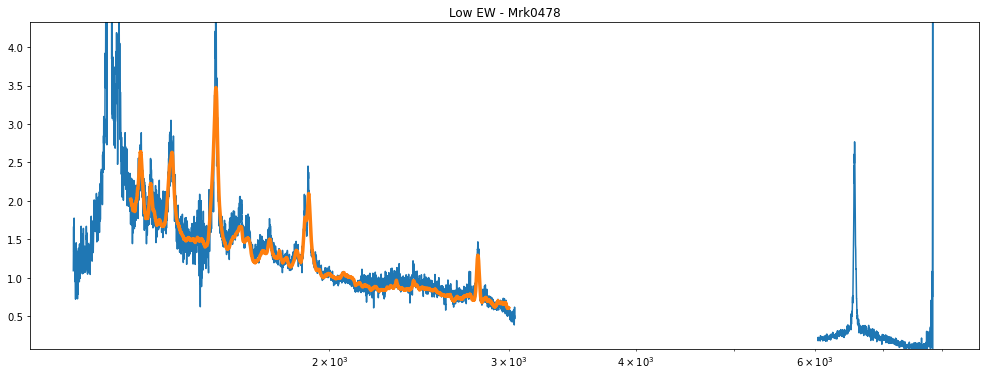

/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in true_divide
/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in true_divide
/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in true_divide


N = 2.00, Try Number 0


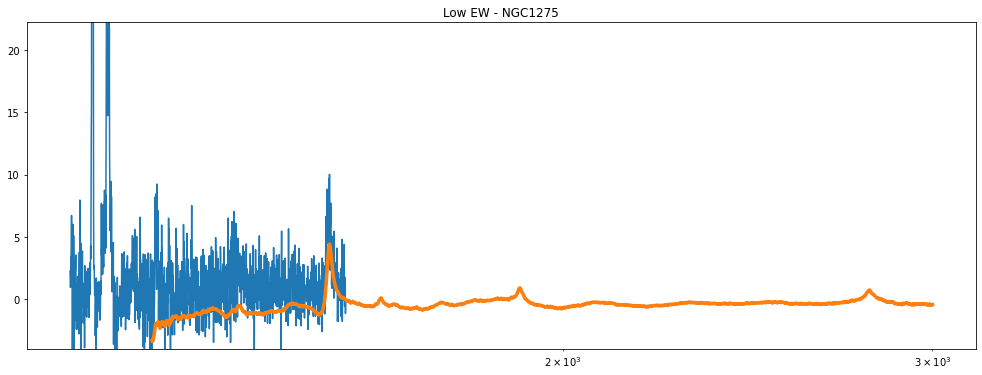

N = 4.25, Try Number 10


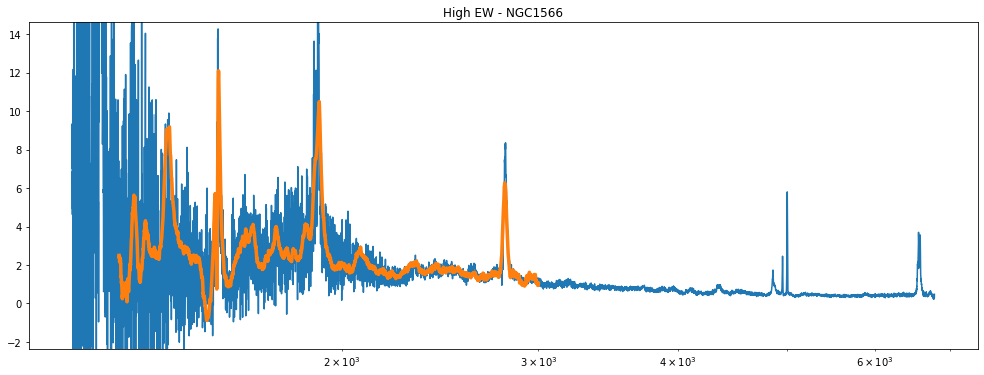

N = 4.25, Try Number 10


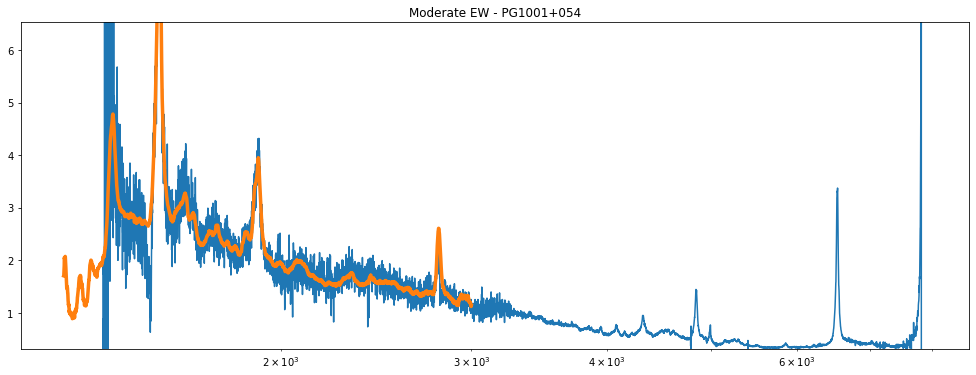

/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in true_divide
/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in true_divide
/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in true_divide


N = 2.00, Try Number 0


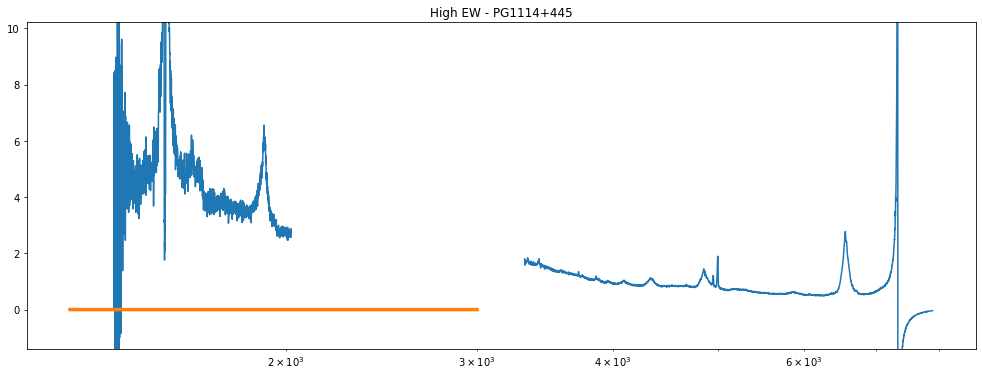

N = 2.00, Try Number 0


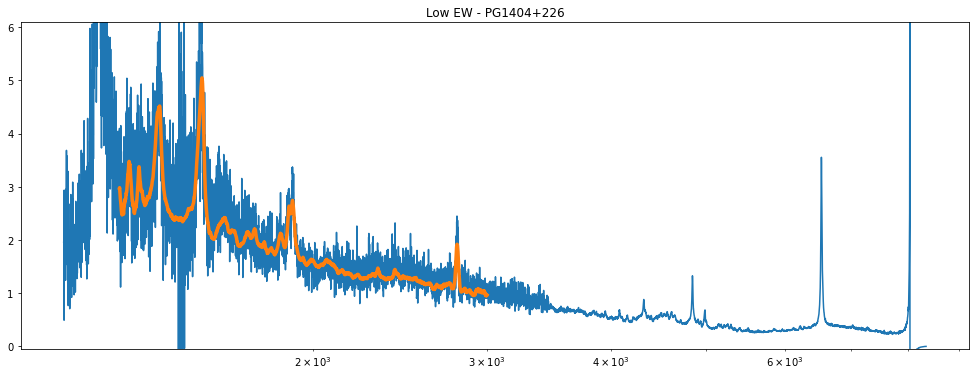

/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in true_divide
/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in true_divide
/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in true_divide


N = 2.00, Try Number 0


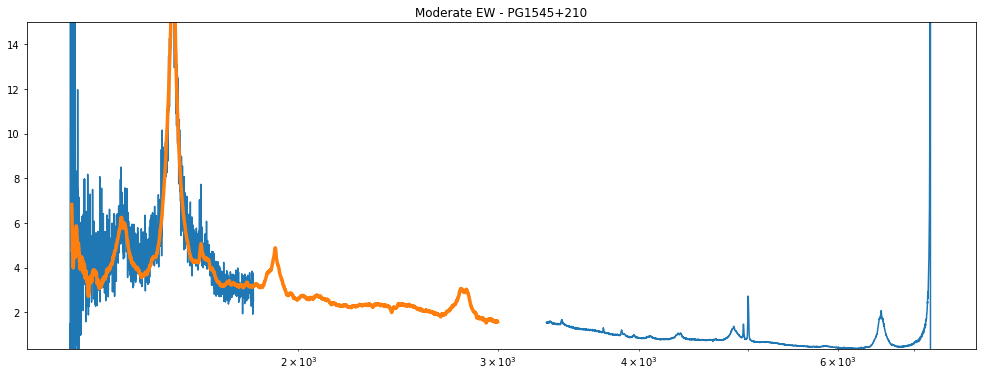

/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in true_divide
/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in true_divide
/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in true_divide


N = 2.00, Try Number 0


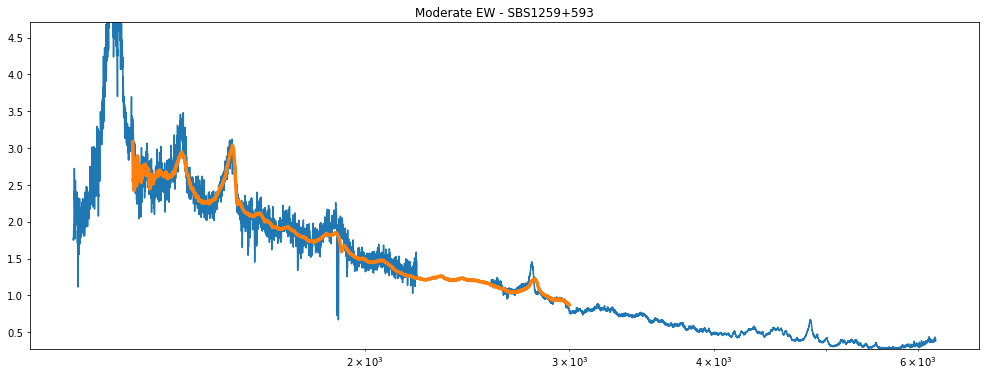

/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in true_divide
/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in true_divide
/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in true_divide


N = 2.00, Try Number 0


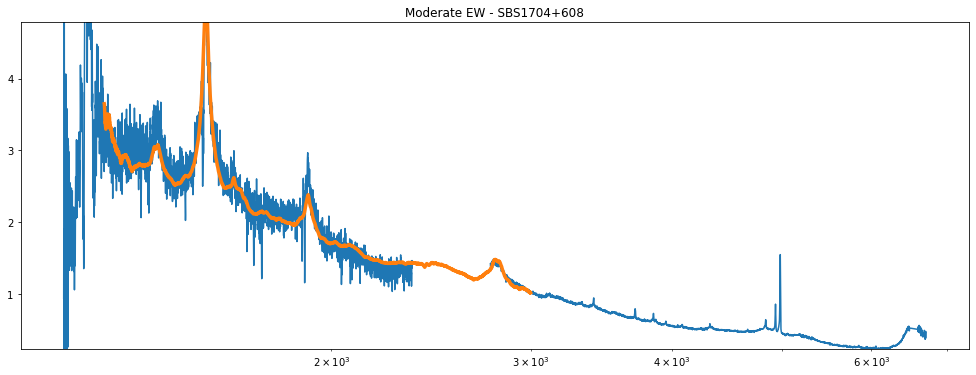

N = 4.25, Try Number 10


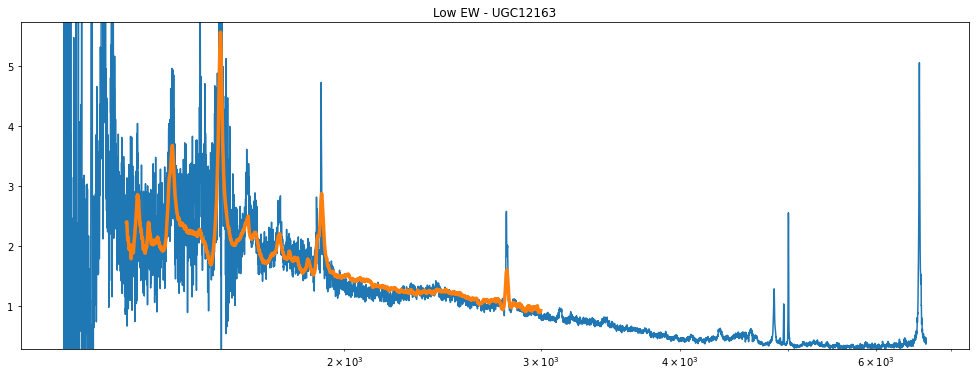

N = 2.00, Try Number 0


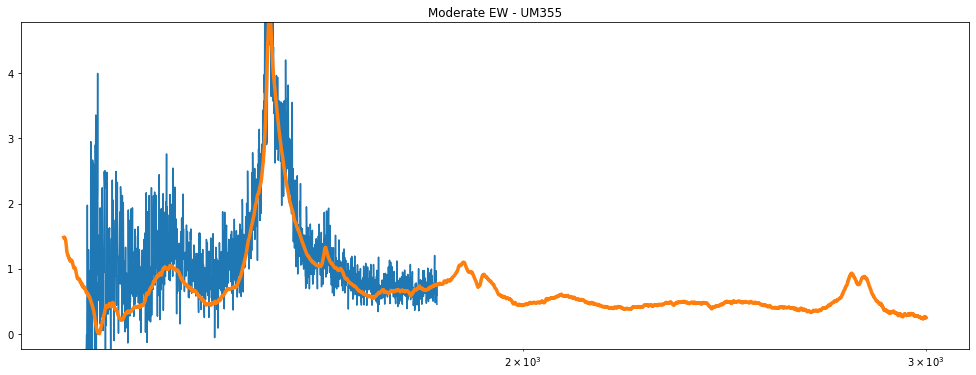

In [11]:
#path = "/Users/trevormccaffrey/Desktop/HST/AllData/SulenticAllData/Final_rebinned_tvm/"
#path = "/Volumes/Macintosh HD 1/Users/trevormccaffrey/Desktop/HST/AllData/SulenticAllData/Final_rebinned_tvm/"
#path = "/Users/Trevor1/Dropbox/HST/Sulentic_spectra/Sulentic_rebinned/"
path = "/Users/trevormccaffrey/Dropbox/HST/Sulentic_spectra/Sulentic_rebinned/"
for spec in np.sort([x for x in os.listdir(path) if not x.startswith(".")]):
    strlist = spec.split("_")
    if "FOS" in strlist and sul_dat.iloc[sul_name==strlist[0],col_num].values[0] in S2N_groupnum:
        #print("%s%s"%(path,spec))
        #5print(strlist[0])
        spec = fits.open("%s%s"%(path,spec))
        wave_orig = spec[1].data["Rest-frame Wavelength"]
        z    = spec[1].data["Redshift"][0]
        flux_orig = spec[1].data["Coadded Flux"]
        flux_orig, morph_coeff = morph(wave_orig, flux_orig)
        flux_orig /= np.nanmedian(flux_orig)
        errs_orig = spec[1].data["Coadded Flux Errors"] / np.nanmedian(flux_orig) * morph_coeff
        mask_orig = spec[1].data["Bad Pixel Mask"]
        
        #Mask NAL regions
        #If spectrum lies 3sigma below continuum, mask that pixel and three blueward+redward
        sudo_cont = SDSS_pixel_filter(wave_orig, flux_orig, 30)
        for i in range(len(wave_orig)):
            if (sudo_cont[i]-flux_orig[i]) > 3*errs_orig[i]:
                mask_orig[max(0,i-3):min(len(wave_orig),i+4)] = 1
        
        #Initial reconstruction on unmasked part of spectrum
        #wave_reconst, reconstruction_orig = do_ICA(wave_orig, flux_orig, errs_orig, mask_orig, strlist[0], plot_spectrum=False)
        wave_reconst, reconstruction = do_ICA(wave_orig, flux_orig, errs_orig, mask_orig, strlist[0], plot_spectrum=False)
        #print((reconstruction_orig==reconstruction).all())
        #plot_spec(wave, flux, errs, mask, strlist[0])
        
        #Iterative masking for broad absorption
        N = 2
        #Break here if N > 4
        while N <= 4:
            #Start from scratch with original wave, flux, etc
            wave  = wave_orig.copy()
            flux  = flux_orig.copy()
            errs  = errs_orig.copy()
            mask  = mask_orig.copy()
            niter = 0
            while niter < 10:
                nbad = 0
                #Work out the window from full spec we're working on
                wave_begin = max( min(wave_reconst), min(wave) )
                wave_end   = min( max(wave_reconst), max(wave) )
                ind_begin = np.argmin( abs(wave-wave_begin) )
                ind_end   = np.argmin( abs(wave-wave_end) )

                #Do the actual masking
                for i in range(ind_begin, ind_end+1):
                    #ind_reconst = np.argmin( abs(wave[i]-wave_reconst) )
                    i_left  = max(ind_begin, i-30)
                    i_right = min(ind_end, i+30)
                    ir_left  = np.argmin( abs(wave[i_left]-wave_reconst) )
                    ir_right = np.argmin( abs(wave[i_right]-wave_reconst) )
                    badpix = (reconstruction[ir_left:ir_right+1]-flux[i_left:i_right+1]) > N*errs[i_left:i_right+1]
                    if badpix.sum() > (len(badpix)/2):
                        nbad += 1
                        mask[max(ind_begin,i-10):min(ind_end,i+11)] = 1
                        
                #If no badpix, mask has converged and we can break
                if nbad == 0:
                    break
                else:
                    niter += 1
                    #print("N = %.2f, Try Number %d" % (N,niter))
                    wave_reconst, reconstruction = do_ICA(wave, flux, errs, mask, strlist[0], plot_spectrum=False)
                    
            #Mask converge with 
            if nbad == 0:
                break
            #Mask did not converge, try again with stricter masking criterion
            else:
                N += 0.25
    
        print("N = %.2f, Try Number %d" % (N,niter))
        wave_reconst, reconstruction = do_ICA(wave, flux, errs, mask, strlist[0])

In [12]:
for i in range(1,3+1):
    print(i)

1
2
3
